In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os.path as osp

measurements = pd.read_csv('pca_version.txt', sep='\s+', names = ['wavelength', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2'])
central_wav = 15272

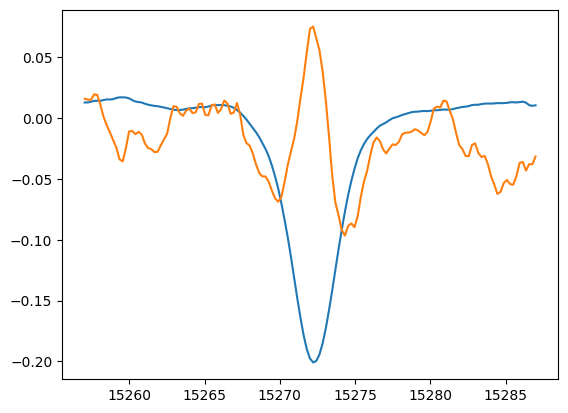

In [2]:
measurements['uncertainty'] = np.ones_like(measurements['PC1_1'])*0.1

plt.plot(measurements['wavelength'], measurements['PC1_1'])
plt.plot(measurements['wavelength'], measurements['PC2_2']*20)


In [3]:
fudges = [5000, 2000]
errs =  h5py.File('jackknife_dib.h5', "r")
errs.keys()

<KeysViewHDF5 ['cov', 'mean', 'var']>

In [10]:
import subprocess
import os
import uuid
import shutil
import h5py
import emcee
import time

# Constants and paths
PGO_TEMPLATE = "asym_top_0.pgo"
JULIA_SCRIPT = "ingest_pgo_asymtop_emcee.jl"
TEMP_DIR = "pgo_temp"
os.makedirs(TEMP_DIR, exist_ok=True)

def filename_base(T, AB_base, C_base, frac_AB, frac_C):
    return f"T{T:.1f}_AB{AB_base:.6f}_C{C_base:.6f}_FAB{frac_AB:.4f}_FC{frac_C:.4f}"

def generate_pgopher_input(T, AB_base, C_base, frac_AB, frac_C):
    A_g = B_g = AB_base
    C_g = C_base
    A_e = B_e = AB_base * frac_AB
    C_e = C_base * frac_C

    base = filename_base(T, AB_base, C_base, frac_AB, frac_C)
    pgo_file = os.path.join(TEMP_DIR, f"temp_{base}.pgo")
    spec_txt = os.path.join(TEMP_DIR, f"spec_{base}.txt")

    awk_script = f'''
    awk -v temp="{T}" \\
        -v A_ground="{A_g}" -v B_ground="{B_g}" -v C_ground="{C_g}" \\
        -v A_excited="{A_e}" -v B_excited="{B_e}" -v C_excited="{C_e}" '
    BEGIN {{ inside_ground = 0; inside_excited = 0; }}
    /<Parameter Name="Temperature" Value="/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" temp "\\"")
    }}
    /<AsymmetricManifold Name="Ground"/ {{ inside_ground = 1 }}
    /<AsymmetricManifold Name="Excited"/ {{ inside_excited = 1 }}
    /<\\/AsymmetricManifold>/ {{ inside_ground = 0; inside_excited = 0 }}
    inside_ground && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_ground "\\"") }}
    inside_ground && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_ground "\\"") }}
    inside_ground && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_ground "\\"") }}
    inside_excited && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_excited "\\"") }}
    inside_excited && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_excited "\\"") }}
    inside_excited && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_excited "\\"") }}
    {{ print }}
    ' {PGO_TEMPLATE} > {pgo_file}
    '''

    subprocess.run(awk_script, shell=True, check=True, executable="/bin/bash")

    # Run PGOPHER
    subprocess.run(["./pgo", pgo_file, "-o", spec_txt], check=True, stdout=subprocess.DEVNULL)
    return spec_txt, base

def run_julia_convolution(spec_txt, base):
    output_h5 = os.path.join(TEMP_DIR, f"convolved_{base}")
    subprocess.run([
        "julia", JULIA_SCRIPT, spec_txt, output_h5
    ], check=True)
    return output_h5+'.h5'

def read_h5_spectrum(h5_file):
    with h5py.File(h5_file, "r") as f:
        # spectrum = f['spectra'][:, 0, 0, 0, 0, 0]
        spectrum = f['spectra'][:]
        wavelength = f['wavelengths'][:]
    return wavelength, spectrum

def compute_likelihood(model_flux, data_flux, noise_std, c = 35):
    scalar = np.dot(data_flux[c:-c], model_flux[c:-c])/np.dot(model_flux[c:-c], model_flux[c:-c])
    chi2 = np.sum((data_flux[c:-c] - scalar*model_flux[c:-c])**2 / noise_std[c:-c]**2)
    return -0.5 * chi2

def model_log_likelihood(params, data_wavelength, data_flux, noise_std):
    try:
        T, AB_base, C_base, frac_AB, frac_C = params
        spec_txt, base = generate_pgopher_input(T, AB_base, C_base, frac_AB, frac_C)
        print(spec_txt)
        h5_file = run_julia_convolution(spec_txt, base)
        model_wavelength, model_flux = read_h5_spectrum(h5_file)

        lnlike = compute_likelihood(model_flux, data_flux, noise_std)

        # Clean up
        os.remove(spec_txt)
        os.remove('pgo_temp/temp'+spec_txt[13:-4]+'.pgo')
        os.remove(h5_file)
        return lnlike
    except Exception as e:
        print(f"Error for params {params}: {e}")
        return -np.inf


In [11]:
ndim = 5
nwalkers = 16
nsteps = 2

noise_std1 = fudges[0]*errs['var'][:, 0] 
noise_std2 = fudges[1]*errs['var'][:, 1]

# Replace with your actual data
data_wavelength = measurements['wavelength']
data_flux = measurements['PC1_1']
# Starting guess for each parameter
p0_center = [30, 0.002, 0.006, 1.0005, 1.0005]
p0 = p0_center*(1+0.01 * np.random.randn(nwalkers, ndim))
start = time.time()
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, model_log_likelihood,
    args=(data_wavelength, data_flux, noise_std1)
)

sampler.run_mcmc(p0, nsteps, progress=True)
stop = time.time()

pgo_temp/spec_T30.0_AB0.002026_C0.006056_FAB1.0127_FC0.9912.txt
pgo_temp/spec_T30.5_AB0.002000_C0.006003_FAB0.9792_FC1.0027.txt
pgo_temp/spec_T29.3_AB0.002009_C0.005976_FAB1.0108_FC0.9972.txt
pgo_temp/spec_T30.1_AB0.001983_C0.006052_FAB0.9990_FC1.0013.txt
pgo_temp/spec_T30.3_AB0.002000_C0.005979_FAB1.0042_FC0.9855.txt
pgo_temp/spec_T30.3_AB0.001998_C0.005833_FAB1.0074_FC0.9997.txt
pgo_temp/spec_T29.4_AB0.001990_C0.006012_FAB0.9924_FC1.0001.txt
pgo_temp/spec_T29.5_AB0.001997_C0.006136_FAB1.0136_FC1.0044.txt
pgo_temp/spec_T30.6_AB0.002004_C0.005954_FAB0.9933_FC1.0001.txt
pgo_temp/spec_T30.1_AB0.002034_C0.006125_FAB0.9786_FC1.0014.txt
pgo_temp/spec_T30.2_AB0.002010_C0.005985_FAB1.0068_FC0.9991.txt
pgo_temp/spec_T30.1_AB0.002019_C0.005945_FAB1.0087_FC1.0099.txt
pgo_temp/spec_T30.0_AB0.001975_C0.005892_FAB1.0061_FC0.9945.txt
pgo_temp/spec_T30.3_AB0.001970_C0.006088_FAB0.9995_FC0.9986.txt
pgo_temp/spec_T29.9_AB0.001989_C0.006088_FAB0.9944_FC1.0071.txt
pgo_temp/spec_T29.5_AB0.002011_C0.006124

  0%|                                                                                       | 0/2 [00:00<?, ?it/s]

pgo_temp/spec_T31.6_AB0.002009_C0.005994_FAB0.9663_FC1.0052.txt
pgo_temp/spec_T30.4_AB0.002013_C0.005921_FAB1.0085_FC0.9727.txt
pgo_temp/spec_T30.0_AB0.001996_C0.005889_FAB1.0027_FC0.9998.txt
pgo_temp/spec_T29.2_AB0.001993_C0.006186_FAB1.0158_FC1.0061.txt
pgo_temp/spec_T30.0_AB0.002026_C0.005914_FAB1.0101_FC1.0184.txt
pgo_temp/spec_T30.0_AB0.001976_C0.005852_FAB1.0075_FC0.9937.txt
pgo_temp/spec_T29.8_AB0.001991_C0.006097_FAB0.9931_FC1.0087.txt
pgo_temp/spec_T29.3_AB0.002021_C0.006133_FAB1.0118_FC0.9810.txt
pgo_temp/spec_T30.0_AB0.002025_C0.006051_FAB1.0124_FC0.9914.txt
pgo_temp/spec_T29.3_AB0.002008_C0.005969_FAB1.0101_FC0.9975.txt
pgo_temp/spec_T29.9_AB0.001968_C0.006117_FAB0.9943_FC1.0155.txt
pgo_temp/spec_T29.5_AB0.001966_C0.005916_FAB0.9769_FC1.0153.txt
pgo_temp/spec_T30.8_AB0.002007_C0.005933_FAB0.9848_FC1.0114.txt
pgo_temp/spec_T30.1_AB0.002028_C0.006102_FAB0.9813_FC1.0007.txt
pgo_temp/spec_T30.2_AB0.002009_C0.005984_FAB1.0066_FC0.9981.txt
pgo_temp/spec_T30.3_AB0.001962_C0.006119

 50%|███████████████████████████████████████                                       | 1/2 [05:11<05:11, 311.13s/it]

pgo_temp/spec_T29.9_AB0.002033_C0.006066_FAB1.0230_FC0.9878.txt
pgo_temp/spec_T30.1_AB0.001989_C0.005981_FAB1.0006_FC1.0007.txt
pgo_temp/spec_T30.3_AB0.002000_C0.005983_FAB1.0008_FC0.9878.txt
pgo_temp/spec_T30.4_AB0.002013_C0.006009_FAB0.9889_FC1.0003.txt
pgo_temp/spec_T30.8_AB0.002019_C0.005857_FAB1.0008_FC0.9928.txt
pgo_temp/spec_T30.1_AB0.002008_C0.005918_FAB1.0058_FC1.0051.txt
pgo_temp/spec_T30.0_AB0.001976_C0.006125_FAB1.0041_FC1.0031.txt
pgo_temp/spec_T30.2_AB0.001971_C0.006061_FAB0.9840_FC1.0226.txt
pgo_temp/spec_T30.4_AB0.002004_C0.005995_FAB0.9911_FC1.0007.txt
pgo_temp/spec_T29.6_AB0.002008_C0.005974_FAB1.0090_FC0.9976.txt
pgo_temp/spec_T30.1_AB0.001997_C0.005896_FAB1.0018_FC0.9998.txt
pgo_temp/spec_T29.3_AB0.001989_C0.006017_FAB0.9908_FC1.0021.txt
pgo_temp/spec_T29.7_AB0.002002_C0.006030_FAB1.0098_FC1.0047.txt
pgo_temp/spec_T30.1_AB0.002015_C0.006105_FAB0.9847_FC1.0010.txt
pgo_temp/spec_T29.9_AB0.001968_C0.005878_FAB1.0090_FC0.9932.txt
pgo_temp/spec_T28.1_AB0.002038_C0.006308

100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [10:20<00:00, 310.44s/it]


In [7]:
from multiprocessing import Pool, cpu_count, get_context
import multiprocessing as mp
mp.set_start_method("fork", force=True)

import subprocess
import os
import uuid
import shutil
import h5py
import emcee
import time

# Constants and paths
PGO_TEMPLATE = "asym_top_0.pgo"
JULIA_SCRIPT = "ingest_pgo_asymtop_emcee.jl"
TEMP_DIR = "pgo_temp"
os.makedirs(TEMP_DIR, exist_ok=True)

def filename_base(T, AB_base, C_base, frac_AB, frac_C):
    return f"T{T:.3f}_AB{AB_base:.7f}_C{C_base:.7f}_FAB{frac_AB:.5f}_FC{frac_C:.5f}"

def generate_pgopher_input(T, AB_base, C_base, frac_AB, frac_C):
    A_g = B_g = AB_base
    C_g = C_base
    A_e = B_e = AB_base * frac_AB
    C_e = C_base * frac_C

    base = filename_base(T, AB_base, C_base, frac_AB, frac_C)
    pgo_file = os.path.join(TEMP_DIR, f"temp_{base}.pgo")
    spec_txt = os.path.join(TEMP_DIR, f"spec_{base}.txt")

    awk_script = f'''
    awk -v temp="{T}" \\
        -v A_ground="{A_g}" -v B_ground="{B_g}" -v C_ground="{C_g}" \\
        -v A_excited="{A_e}" -v B_excited="{B_e}" -v C_excited="{C_e}" '
    BEGIN {{ inside_ground = 0; inside_excited = 0; }}
    /<Parameter Name="Temperature" Value="/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" temp "\\"")
    }}
    /<AsymmetricManifold Name="Ground"/ {{ inside_ground = 1 }}
    /<AsymmetricManifold Name="Excited"/ {{ inside_excited = 1 }}
    /<\\/AsymmetricManifold>/ {{ inside_ground = 0; inside_excited = 0 }}
    inside_ground && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_ground "\\"") }}
    inside_ground && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_ground "\\"") }}
    inside_ground && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_ground "\\"") }}
    inside_excited && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_excited "\\"") }}
    inside_excited && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_excited "\\"") }}
    inside_excited && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_excited "\\"") }}
    {{ print }}
    ' {PGO_TEMPLATE} > {pgo_file}
    '''

    subprocess.run(awk_script, shell=True, check=True, executable="/bin/bash")

    # Run PGOPHER
    subprocess.run(["./pgo", pgo_file, "-o", spec_txt], check=True, stdout=subprocess.DEVNULL)
    return spec_txt, base

def run_julia_convolution(spec_txt, base):
    output_h5 = os.path.join(TEMP_DIR, f"convolved_{base}")
    subprocess.run([
        "julia", JULIA_SCRIPT, spec_txt, output_h5
    ], check=True)
    return output_h5+'.h5'

def read_h5_spectrum(h5_file):
    with h5py.File(h5_file, "r") as f:
        # spectrum = f['spectra'][:, 0, 0, 0, 0, 0]
        spectrum = f['spectra'][:]
        wavelength = f['wavelengths'][:]
    return wavelength, spectrum

def log_prior(params):
    T, AB, C, frac_AB, frac_C = params

    # Log-normal prior on T
    if T <= 3 or T > 100:
        return -np.inf
    mu = np.log(30)
    sigma = 0.5
    temp_logprior = -np.log(T * sigma * np.sqrt(2 * np.pi)) - ((np.log(T) - mu)**2) / (2 * sigma**2)

    # AB flat prior: [0.001, 0.01]
    if AB < 0.001 or AB > 0.01:
        return -np.inf
    ab_logprior = 0.0

    # C flat prior: [0.004, 0.03]
    if C < 0.004 or C > 0.03:
        return -np.inf
    c_logprior = 0.0

    # Fraction AB prior: min at 1, falls off fast above 1
    if frac_AB < 1:
        return -np.inf
    frac_ab_logprior = -10 * (frac_AB - 1)**2  # steeper than Gaussian

    # Fraction C prior: min at 1, also steep falloff
    if frac_C < 1:
        return -np.inf
    frac_c_logprior = -10 * (frac_C - 1)**2

    return temp_logprior + ab_logprior + c_logprior + frac_ab_logprior + frac_c_logprior

def compute_negloglikelihood(model_flux, model_flux_dT, data_flux, data_flux_dT, noise_std, noise_std_dT, c = 35, gf = 0.1):
    model_spec = gaussian_filter( model_flux[c:-c], gf)
    model_spec_dT = gaussian_filter( model_flux[c:-c], gf) - gaussian_filter( model_flux_dT[c:-c], gf)

    measurement = data_flux[c:-c]
    measurement_dT = data_flux_dT[c:-c]
    
    noise_std = noise_std[c:-c]
    noise_std_dT = noise_std_dT[c:-c]
    
    M = np.vstack([model_spec, np.ones_like(model_spec)]).T
    coeffs, _, _, _ = np.linalg.lstsq(M, measurement, rcond=None)
    scalar, offset = coeffs

    fit = scalar * model_spec + offset
    chi = (measurement - fit)/noise_std
    chi2 = np.sum(chi ** 2)

    # Build design matrix: [spec, model_spec, offset]
    M = np.vstack([model_spec, model_spec_dT, np.ones_like(model_spec)]).T

    # Solve for two scalars and offset
    coeffs, _, _, _ = np.linalg.lstsq(M, measurement_dT, rcond=None)
    scalar1, scalar2, offset = coeffs

    # Compute fit and residual
    fit = scalar1 * model_spec + scalar2 * model_spec_dT + offset
    chi = (measurement_dT - fit)/noise_std_dT

    chi2 += np.sum(chi ** 2)
                        
    return 0.5 * chi2

def model_log_likelihood(params, data_wavelength, data_flux, data_flux_dT, noise_std, noise_std_dT):

    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
        
    try:
        T, AB_base, C_base, frac_AB, frac_C = params
        spec_txt, base = generate_pgopher_input(T, AB_base, C_base, frac_AB, frac_C)
        h5_file = run_julia_convolution(spec_txt, base)
        model_wavelength, model_flux = read_h5_spectrum(h5_file)

        spec_txt, base = generate_pgopher_input(T*1.001, AB_base, C_base, frac_AB, frac_C)
        h5_file = run_julia_convolution(spec_txt, base)
        _, model_flux_dT = read_h5_spectrum(h5_file)

        neglnlike = compute_negloglikelihood(model_flux, model_flux_dT, data_flux, data_flux_dT, noise_std, noise_std_dT)

        # Clean up
        os.remove(spec_txt)
        os.remove('pgo_temp/temp'+spec_txt[13:-4]+'.pgo')
        os.remove(h5_file)
        return neglnlike - lp
        
    except Exception as e:
        print(f"Error for params {params}: {e}")
        return -np.inf

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

ndim = 5
nwalkers = 64
nsteps = 10
ncpu_to_use = 64

fudges = [5000, 2000]
errs =  h5py.File('jackknife_dib.h5', "r")
errs.keys()

noise_std1 = 3*fudges[0]*errs['var'][:, 0] 
noise_std2 = 3*fudges[1]*errs['var'][:, 1]

# Replace with your actual data
data_wavelength = measurements['wavelength']
data_flux = measurements['PC1_1']

with get_context("fork").Pool(processes = ncpu_to_use) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, model_log_likelihood,
    args=(data_wavelength, data_flux, noise_std1), pool=pool)
    startm = time.time()
    p0_center = [30, 0.003, 0.008, 1.001, 1.001]

    # Define relative scales per parameter
    step_scales = [5, 0.0004, 0.001, 0.0004, 0.0004]  # T, AB, C, frac_AB, frac_C
    
    # Build walker initial positions
    p0 = np.array([
        p0_center + np.array(step_scales)/nwalkers * np.random.randn(len(p0_center))
        for _ in range(nwalkers)
    ])
    
    sampler.run_mcmc(p0, nsteps, progress=True)
    end = time.time()
    multi_time = end - startm
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

96 CPUs
emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:

emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params:
emcee: Exception while calling your likelihood function:

emcee: Exception while calling your likelihood function:emcee: Exception while

Traceback (most recent call last):


 {}
  exception:{} 
  exception:
{}
  exception: 

{}{}
{}
 {}{}

Traceback (most recent call last):


{} 




Traceback (most recent call last):




{}
{} 
{}{}  exception:

Traceback (most recent call last):




  exception:
{}{}


{}

{}  exception:  exception:  exception:  exception:{}

{}  exception:

  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


{}
  exception:
{}  exception:


{}

Traceback (most recent call last):



  exception:



Traceback (most recent call last):


  exception:


Traceback (most recent call last):


{}



Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)



  exception:{}  exception:

  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:

Traceback (most recent call last):



{}


Traceback (most recent call last):
Traceback (most recent call last):





  exception:

Traceback (most recent call last):


  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)



  exception:


Traceback (most recent call last):


  exception:  exception:  exception:
  exception:


Traceback (most recent call last):







  exception:  exception:



TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'



  exception:




Traceback (most recent call last):


  exception:  exception:

  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):
Traceback (most recent call last):



  exception:  exception:


  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:  exception:


  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:

  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:

TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'


TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'



  exception:


  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:  exception:  exception:

  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:

TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'
Traceback (most recent call last):



  exception:


  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)




  exception:
  exception:

  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):


  exception:

Traceback (most recent call last):




  exception:

Traceback (most recent call last):
Traceback (most recent call last):


  exception:


Traceback (most recent call last):


  exception:

Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):
TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'



  exception:


  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'
Traceback (most recent call last):


  exception:


TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'


TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'


  exception:

Traceback (most recent call last):



  exception:

Traceback (most recent call last):
TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'
TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'


Traceback (most recent call last):


TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'


  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):
Traceback (most recent call last):
TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'


Traceback (most recent call last):
TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'
Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):


  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):
Traceback (most recent call last):


  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'
TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'
  File "/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f

TypeError: model_log_likelihood() missing 2 required positional arguments: 'noise_std' and 'noise_std_dT'

In [5]:
from multiprocessing import Pool, cpu_count, get_context
import multiprocessing as mp
mp.set_start_method("fork", force=True)

import subprocess
import os
import uuid
import shutil
import h5py
import emcee
import time
from scipy.ndimage import gaussian_filter

# Constants and paths
PGO_TEMPLATE = "asym_top_0.pgo"
JULIA_SCRIPT = "ingest_pgo_asymtop_emcee.jl"
TEMP_DIR = "pgo_temp"
os.makedirs(TEMP_DIR, exist_ok=True)

def filename_base(T, AB_base, C_base, frac_AB, frac_C):
    return f"T{T:.3f}_AB{AB_base:.7f}_C{C_base:.7f}_FAB{frac_AB:.5f}_FC{frac_C:.5f}"

def generate_pgopher_input(T, AB_base, C_base, frac_AB, frac_C):
    A_g = B_g = AB_base
    C_g = C_base
    A_e = B_e = AB_base * frac_AB
    C_e = C_base * frac_C

    base = filename_base(T, AB_base, C_base, frac_AB, frac_C)
    pgo_file = os.path.join(TEMP_DIR, f"temp_{base}.pgo")
    spec_txt = os.path.join(TEMP_DIR, f"spec_{base}.txt")

    awk_script = f'''
    awk -v temp="{T}" \\
        -v A_ground="{A_g}" -v B_ground="{B_g}" -v C_ground="{C_g}" \\
        -v A_excited="{A_e}" -v B_excited="{B_e}" -v C_excited="{C_e}" '
    BEGIN {{ inside_ground = 0; inside_excited = 0; }}
    /<Parameter Name="Temperature" Value="/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" temp "\\"")
    }}
    /<AsymmetricManifold Name="Ground"/ {{ inside_ground = 1 }}
    /<AsymmetricManifold Name="Excited"/ {{ inside_excited = 1 }}
    /<\\/AsymmetricManifold>/ {{ inside_ground = 0; inside_excited = 0 }}
    inside_ground && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_ground "\\"") }}
    inside_ground && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_ground "\\"") }}
    inside_ground && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_ground "\\"") }}
    inside_excited && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_excited "\\"") }}
    inside_excited && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_excited "\\"") }}
    inside_excited && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_excited "\\"") }}
    {{ print }}
    ' {PGO_TEMPLATE} > {pgo_file}
    '''

    subprocess.run(awk_script, shell=True, check=True, executable="/bin/bash")

    # Run PGOPHER
    subprocess.run(["./pgo", pgo_file, "-o", spec_txt], check=True, stdout=subprocess.DEVNULL)
    return spec_txt, base

def run_julia_convolution(spec_txt, base):
    output_h5 = os.path.join(TEMP_DIR, f"convolved_{base}")
    subprocess.run([
        "julia", JULIA_SCRIPT, spec_txt, output_h5
    ], check=True)
    return output_h5+'.h5'

def read_h5_spectrum(h5_file):
    with h5py.File(h5_file, "r") as f:
        # spectrum = f['spectra'][:, 0, 0, 0, 0, 0]
        spectrum = f['spectra'][:]
        wavelength = f['wavelengths'][:]
    return wavelength, spectrum

def log_prior(params):
    T, AB, C, frac_AB, frac_C = params

    # Log-normal prior on T
    if T <= 2 or T > 100:
        return -np.inf
    mu = np.log(30)
    sigma = 1
    temp_logprior = -np.log(T * sigma * np.sqrt(2 * np.pi)) - ((np.log(T) - mu)**2) / (2 * sigma**2)

    # AB flat prior: [0.001, 0.01]
    if AB < 0.001 or AB > 0.01:
        return -np.inf
    ab_logprior = 0.0

    # C flat prior: [0.004, 0.03]
    if C < 0.004 or C > 0.03:
        return -np.inf
    c_logprior = 0.0

    # Fraction AB prior: min at 1, falls off fast above 1
    if frac_AB < 1:
        return -np.inf
    frac_ab_logprior = -10 * (frac_AB - 1)**2  # steeper than Gaussian

    # Fraction C prior: min at 1, also steep falloff
    if frac_C < 1:
        return -np.inf
    frac_c_logprior = -10 * (frac_C - 1)**2

    return temp_logprior + ab_logprior + c_logprior + frac_ab_logprior + frac_c_logprior

def compute_loglikelihood(model_flux, model_flux_dT, data_flux, data_flux_dT, noise_std, noise_std_dT, c = 35, gf = 0.1):
    model_spec = gaussian_filter( model_flux[c:-c], gf)
    model_spec_dT = gaussian_filter( model_flux[c:-c], gf) - gaussian_filter( model_flux_dT[c:-c], gf)

    measurement = data_flux[c:-c]
    measurement_dT = data_flux_dT[c:-c]
    
    noise_std = noise_std[c:-c]
    noise_std_dT = noise_std_dT[c:-c]
    
    M = np.vstack([model_spec, np.ones_like(model_spec)]).T
    coeffs, _, _, _ = np.linalg.lstsq(M, measurement, rcond=None)
    scalar, offset = coeffs

    fit = scalar * model_spec + offset
    chi = (measurement - fit)/noise_std
    chi2 = np.sum(chi ** 2)

    # Build design matrix: [spec, model_spec, offset]
    M = np.vstack([model_spec, model_spec_dT, np.ones_like(model_spec)]).T

    # Solve for two scalars and offset
    coeffs, _, _, _ = np.linalg.lstsq(M, measurement_dT, rcond=None)
    scalar1, scalar2, offset = coeffs

    # Compute fit and residual
    fit = scalar1 * model_spec + scalar2 * model_spec_dT + offset
    chi = (measurement_dT - fit)/noise_std_dT

    chi2 += np.sum(chi ** 2)
                        
    return -0.5 * chi2

def model_log_likelihood(params, data_wavelength, data_flux, data_flux_dT, noise_std, noise_std_dT):

    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
        
    try:
        
        T, AB_base, C_base, frac_AB, frac_C = params
        spec_txt, base = generate_pgopher_input(T, AB_base, C_base, frac_AB, frac_C)
        h5_file = run_julia_convolution(spec_txt, base)
        model_wavelength, model_flux = read_h5_spectrum(h5_file)
        
        spec_txt, base = generate_pgopher_input(T+0.05, AB_base, C_base, frac_AB, frac_C)
        h5_file = run_julia_convolution(spec_txt, base)
        _, model_flux_dT = read_h5_spectrum(h5_file)
        
        neglnlike = compute_loglikelihood(model_flux, model_flux_dT, data_flux, data_flux_dT, noise_std, noise_std_dT)
        
        # Clean up
        os.remove(spec_txt)
        os.remove('pgo_temp/temp'+spec_txt[13:-4]+'.pgo')
        os.remove(h5_file)

        return neglnlike + lp
        
    except Exception as e:
        print(f"Error for params {params}: {e}")
        return -np.inf


from pathlib import Path

directory = Path(TEMP_DIR)

for file in directory.iterdir():
    if file.is_file():
        file.unlink()

ndim = 5
nwalkers = 64
nsteps = 10
ncpu_to_use = 64

fudges = [5000, 2000]
errs =  h5py.File('jackknife_dib.h5', "r")
errs.keys()

noise_std1 = 3*fudges[0]*errs['var'][:, 0] 
noise_std2 = 3*fudges[1]*errs['var'][:, 1]

# Replace with your actual data
data_wavelength = measurements['wavelength']
data_flux = measurements['PC1_1']
data_flux_dT = measurements['PC2_2']

filename = osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/test_backend.h5")
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with get_context("fork").Pool(processes = ncpu_to_use) as pool:
    print('Running!')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, model_log_likelihood, 
    args=(data_wavelength, data_flux_dT, data_flux_dT,  noise_std1, noise_std2), pool = pool, backend=backend)
    startm = time.time()
    p0_center = [20, 0.003, 0.008, 1.001, 1.001]
    
    # Define relative scales per parameter
    step_scales = [15, 0.0015, 0.003, 0.001, 0.001]  # T, AB, C, frac_AB, frac_C
    
    # Build walker initial positions
    p0 = np.array([
        p0_center + np.array(step_scales)/np.sqrt(nwalkers) * np.random.normal(loc = 0, scale = 1, size = len(p0_center))
        for _ in range(nwalkers)
    ])
    sampler.run_mcmc(p0, nsteps, progress=True)
    end = time.time()
    multi_time = end - startm
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

Running!


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [12:04<00:00, 72.43s/it]

Multiprocessing took 767.4 seconds


In [19]:
reader = emcee.backends.HDFBackend(filename)

tau = reader.get_autocorr_time(tol = 0, c =1, quiet = False)
print(tau)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

[nan nan nan nan nan]


ValueError: cannot convert float NaN to integer

In [15]:
log_prob_samples = reader.get_log_prob(discard=0, flat=True, thin=1)
log_prob_samples

array([-45.66289454, -42.59815427, -44.16937544, -49.35665145,
       -41.51376263, -41.97010794, -46.95447124, -41.48279017,
       -44.19732233, -43.02687861, -44.48632522, -44.03943475,
       -44.1598762 , -43.65321474, -44.42641373, -44.46595109,
       -47.15199847, -50.3324323 , -43.99704928, -42.65304217,
       -40.90337704, -44.0066137 , -44.8753384 , -46.33109743,
       -45.39064034, -44.00119533, -45.58095563, -45.60021675,
       -43.7322931 , -45.8109597 , -43.433099  , -43.51468358,
       -44.4180325 , -46.61603913, -45.1783159 , -44.73792719,
       -46.73169781, -44.40794657, -42.7227144 , -46.26700116,
       -43.65593529, -45.19796759, -46.41436141, -45.17884294,
       -46.72823183, -46.48405265, -43.96147796, -45.27074458,
       -44.42471613, -43.77697214, -46.22855454, -41.87700588,
       -40.48857968, -45.89910462, -44.65586356, -44.02028612,
       -47.53776002, -46.94781903, -45.1516694 , -40.32713277,
       -44.86064703, -42.63358344, -44.58378952, -43.03

In [17]:
print("Chain shape:", reader.get_chain().shape)  # (n_steps, n_walkers, n_dim)

Chain shape: (10, 64, 5)


In [ ]:
emcee.autocorr.integrated_time(x, c=5, tol=50, quiet=False, has_walkers=True)

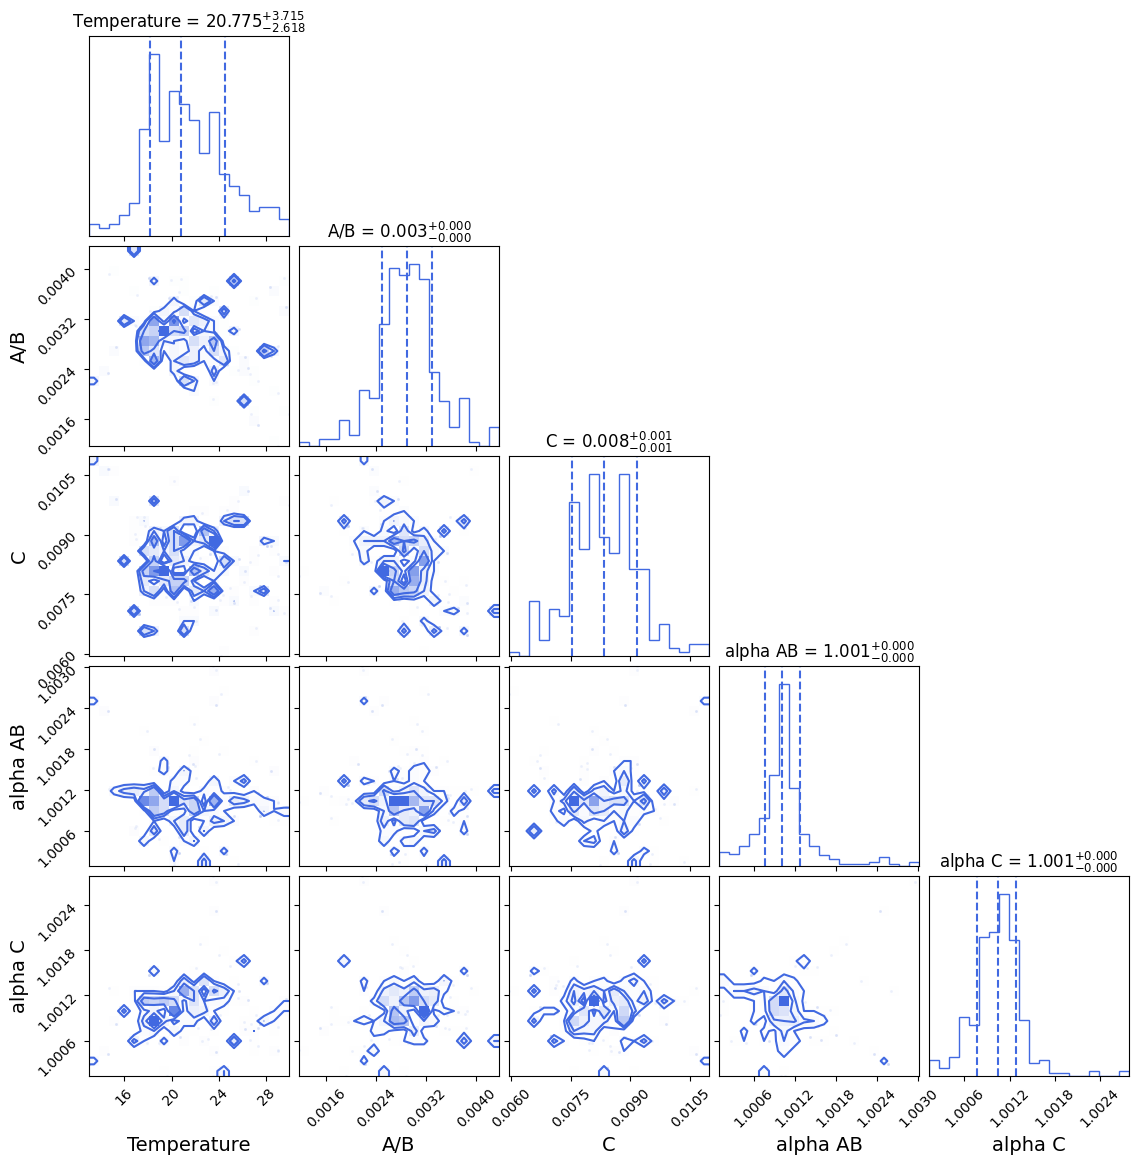

In [20]:
import corner
import numpy as np
import matplotlib.pyplot as plt

burn_in = 5
thin_factor = 1
samples = sampler.get_chain(discard=burn_in, thin=thin_factor, flat=True)

# Parameter names in the order you sampled them
labels = [
    "Temperature", 
    "A/B", 
    "C", 
    "alpha AB", 
    "alpha C"
]

# Make the corner plot
fig = corner.corner(
    samples,
    labels=labels,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".3f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    smooth=0.2,  # Gaussian smoothing
    color="royalblue"
)

plt.show()
